# Skin Cancer Identifier 
# Author: Owen Trudt

In [1]:
# imports
import os 
import pandas as pd 
import sklearn 
import tensorflow as tf 
import numpy as np 
import shutil
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
from PIL import Image
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier


Also I am a little rusty so there might be some things wrong with this model that do not make sense. I am trying to relearn this material and no better way to relearn then trying to solve a problem :) 

# Lets try a different approach, lets do some feature engineering on the images.
These images are similar so if we do some feature extraction we can possibly see some performance gains.
The idea is that I want the initial cnn architecture (with improvements of course because this model is not working well)
but then incorporate a glcm layer? 
Still figuring this out... this is a new technqiue to me

glcm is good for texture, I am working off of the assumption and after looking at some images there will be a texture difference between a benign and malignant skin tag

special s/o to this notebook: https://www.kaggle.com/code/cholisah/my-glcm-and-cnn/notebook, https://www.kaggle.com/code/kevinismail/pneumonia-covid19-classification-with-glcm-and-cnn
I haven't done combinded models before and this notebook basically is the idea I had for this problem so I will be following a similar structure. 

In [73]:
import cv2
from skimage.feature import graycomatrix, graycoprops
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, History
from keras.utils import plot_model
import graphviz
from keras import Input
from keras.regularizers import l2

os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

In [94]:
def glcm_extraction(images): 
    image_data = pd.DataFrame()
    for image in images: 
        df = pd.DataFrame()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        distance = [[1], [3], [5], [3], [3], [7]]
        angles = [[0], [0], [0], [np.pi/4], [np.pi/2]]

        for n, (dist, angle) in enumerate(zip(distance, angles)): 
            glcm = graycomatrix(image, dist, angle)
            glcm_e = graycoprops(glcm, 'energy')[0]
            df['Energy'+str(n)] = glcm_e
            glcm_corr = graycoprops(glcm, 'correlation')[0]
            df['Corr'+str(n)] = glcm_corr       
            glcm_diss = graycoprops(glcm, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = glcm_diss       
            glcm_homm = graycoprops(glcm, 'homogeneity')[0]
            df['Homogen'+str(n)] = glcm_homm       
            glcm_contr = graycoprops(glcm, 'contrast')[0]
            df['Contrast'+str(n)] = glcm_contr
        
        image_data = pd.concat([image_data, df], ignore_index=True)

    return image_data 



In [77]:
train_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/train/"
test_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/test/"

# np array images 
categories_dict = {
  "benign": 0,
  "malignant": 1
}


SIZE = 224
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 50
STEP_SIZE = 28



In [5]:
import fiftyone as fo

# lets experiment with fiftyone and analyze our image data

# create a dataset
train_data_set_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/train/"
name = "skin_cancer_train"

dataset = fo.Dataset.from_images_dir(train_data_set_dir, name=name,)

session = fo.launch_app(dataset)




 100% |███████████████| 2637/2637 [250.2ms elapsed, 0s remaining, 10.7K samples/s]  



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.25.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [7]:
session.close()

In [110]:
train_images = []
train_labels = [] 
images = []

for directory in os.listdir(train_dir): 
    label = categories_dict[directory]
    for img_path in glob.glob(os.path.join(train_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
        train_labels.append(label)
print(len(train_images))
print(len(train_labels))

2637
2637


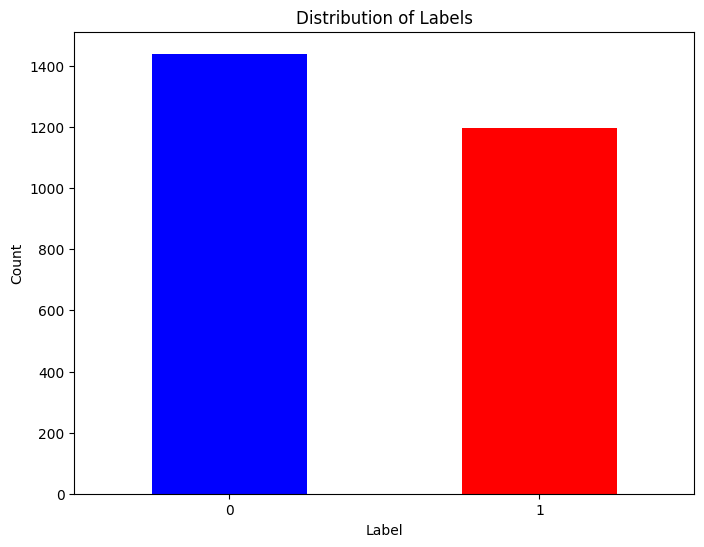

In [111]:
df = pd.DataFrame(train_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [112]:
test_images = []
test_labels = [] 
test_labels_test = []
images = []

for directory in os.listdir(test_dir): 
    label = categories_dict[directory]
    for img_path in glob.glob(os.path.join(test_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(img)
        test_labels.append(label)
        test_labels_test.append(label)
print(len(test_images))
print(len(test_labels))
test_images = np.array(test_images)

660
660


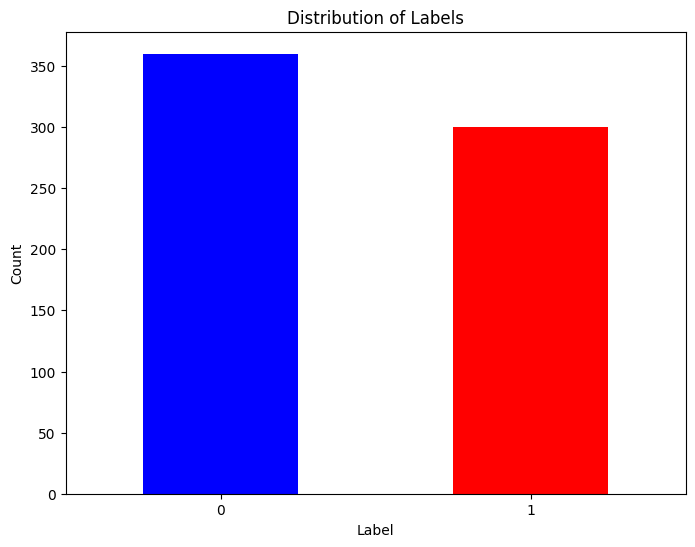

In [113]:
df = pd.DataFrame(test_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [114]:
x_train = np.array(train_images)

In [115]:
train_images, val_images, train_labels, val_labels = train_test_split(x_train, train_labels, test_size=0.2, random_state=44)

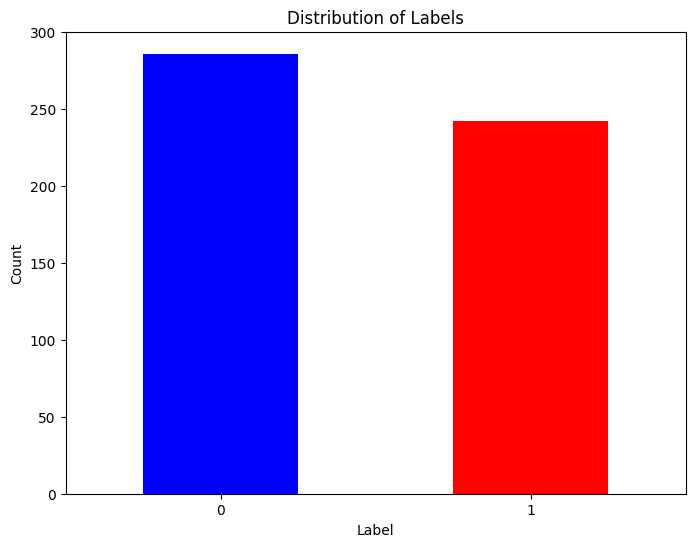

In [116]:
df = pd.DataFrame(val_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [117]:
print("train:",train_images.shape[0])
print("val:", val_images.shape[0])
print("test:", test_images.shape[0])

train: 2109
val: 528
test: 660


In [118]:
train_features = glcm_extraction(train_images)
test_features = glcm_extraction(test_images)
val_features = glcm_extraction(val_images)

In [119]:
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [120]:
pd.set_option("display.max_columns", None)
train_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.032242,0.994855,2.767457,0.338422,16.883848,0.025376,0.984991,4.918693,0.218864,49.471093,0.023114,0.976179,6.301431,0.177150,78.878200,0.024219,0.981681,5.514934,0.198256,60.336580,0.023709,0.980298,5.765918,0.190055,64.679581
1,0.071466,0.953731,2.057135,0.408468,10.339726,0.058763,0.901681,3.173845,0.297392,22.089569,0.054479,0.859808,3.832171,0.258026,31.689600,0.060204,0.909383,3.020433,0.308352,20.382254,0.060534,0.915982,2.933177,0.314456,18.840296
2,0.037756,0.991397,3.074151,0.286051,16.715607,0.031872,0.978749,4.801410,0.203816,41.525028,0.030040,0.968626,5.785775,0.176367,61.649238,0.031686,0.978264,4.853766,0.201677,42.509029,0.032265,0.980174,4.636534,0.209623,38.644736
3,0.021537,0.984526,5.336863,0.205684,62.049067,0.015956,0.940522,10.912633,0.108794,235.103891,0.014229,0.890304,14.766349,0.083136,428.346298,0.016853,0.957404,9.353807,0.125988,168.026317,0.017187,0.957860,8.959963,0.137972,168.141968
4,0.030463,0.981784,5.166160,0.244116,75.734665,0.023331,0.944771,9.354497,0.142293,230.383545,0.021324,0.909166,11.969260,0.118354,380.587329,0.023612,0.946407,9.126978,0.152217,223.925655,0.023960,0.949535,8.744970,0.156712,210.523937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,0.062120,0.988099,2.488629,0.375752,16.004965,0.051992,0.975935,3.824196,0.271621,32.597305,0.048444,0.960713,4.851822,0.235669,53.578543,0.052246,0.978150,3.633106,0.281046,29.641141,0.053809,0.983803,3.270099,0.294172,21.918209
2105,0.076899,0.895488,2.769359,0.385401,31.274804,0.059981,0.746250,4.761676,0.252653,75.975840,0.055768,0.693037,5.565558,0.214834,92.030985,0.062633,0.775661,4.387448,0.273056,67.029117,0.062725,0.729107,4.558278,0.272205,80.827388
2106,0.038229,0.967733,3.502302,0.261105,23.061399,0.029682,0.902345,6.209114,0.160715,70.015595,0.027457,0.848693,7.658288,0.132081,108.903722,0.031442,0.924409,5.437749,0.182225,54.403539,0.031322,0.928177,5.337326,0.181006,51.648412
2107,0.074548,0.995606,2.729140,0.363297,18.186659,0.061176,0.976166,5.748788,0.245724,95.384292,0.057936,0.944998,8.068615,0.215135,213.798842,0.061378,0.982406,4.901368,0.256142,70.437241,0.060960,0.986151,4.634838,0.257571,57.559127


In [121]:
def create_combined_model(learning_rate=float(0.001), kernel_regularizer=0.001): 
    glcm_model_input = Input(shape=(25,))
    x1 = keras.layers.Dense(64, activation='relu')(glcm_model_input)
    x1 = keras.layers.Dense(32, activation='relu')(x1)
    x1 = keras.layers.Dense(16, activation='relu')(x1)

    cnn_input = Input((224,224,3))
    x2 = keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(kernel_regularizer))(cnn_input)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(kernel_regularizer))(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(kernel_regularizer))(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(kernel_regularizer))(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)
    x2 = keras.layers.Flatten()(x2)

    combined = keras.layers.Concatenate()([x1, x2])

    x = keras.layers.Dense(128, activation='relu')(combined)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model([glcm_model_input, cnn_input], x)

    print(model.summary())

    aopt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=aopt, loss=keras.losses.BinaryCrossentropy(), 
                    metrics=[keras.metrics.BinaryAccuracy()])
    
    return model

In [122]:
model = create_combined_model()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 222, 222,  │     14,336 │ input_layer_13[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 222, 222,  │      2,048 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 111, 111,  │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 109, 109,  │  1,179,904 │ dropout_30[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 54, 54,    │          0 │ max_pooling2d_19… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 52, 52,    │    295,040 │ dropout_31[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        512 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 26, 26,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 24, 24,    │     73,792 │ dropout_32[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 64)        │      1,664 │ input_layer_12[0

 Total params: 2,764,401 (10.55 MB)

 Trainable params: 2,762,225 (10.54 MB)

 Non-trainable params: 2,176 (8.50 KB)

None


In [141]:

# # define the learning rate change 
# def exp_decay(epoch):
#     lrate = LEARNING_RTE_SGD * np.exp(-DECAY_RTE_SGD*epoch)
#     return lrate
    
# # learning schedule callback
# loss_history = History()
# lr_rate = LearningRateScheduler(exp_decay)


# # define the optimizer function
# sgd = SGD(learning_rate=LEARNING_RTE_SGD, momentum=MOMENTUM_SGD, decay=DECAY_RTE_SGD, nesterov=False)

# model.compile(optimizer=sgd, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
#                     metrics=[keras.metrics.BinaryAccuracy()])


c:\Users\ot7sl\Favorites\repo_house\PersonalProjects\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


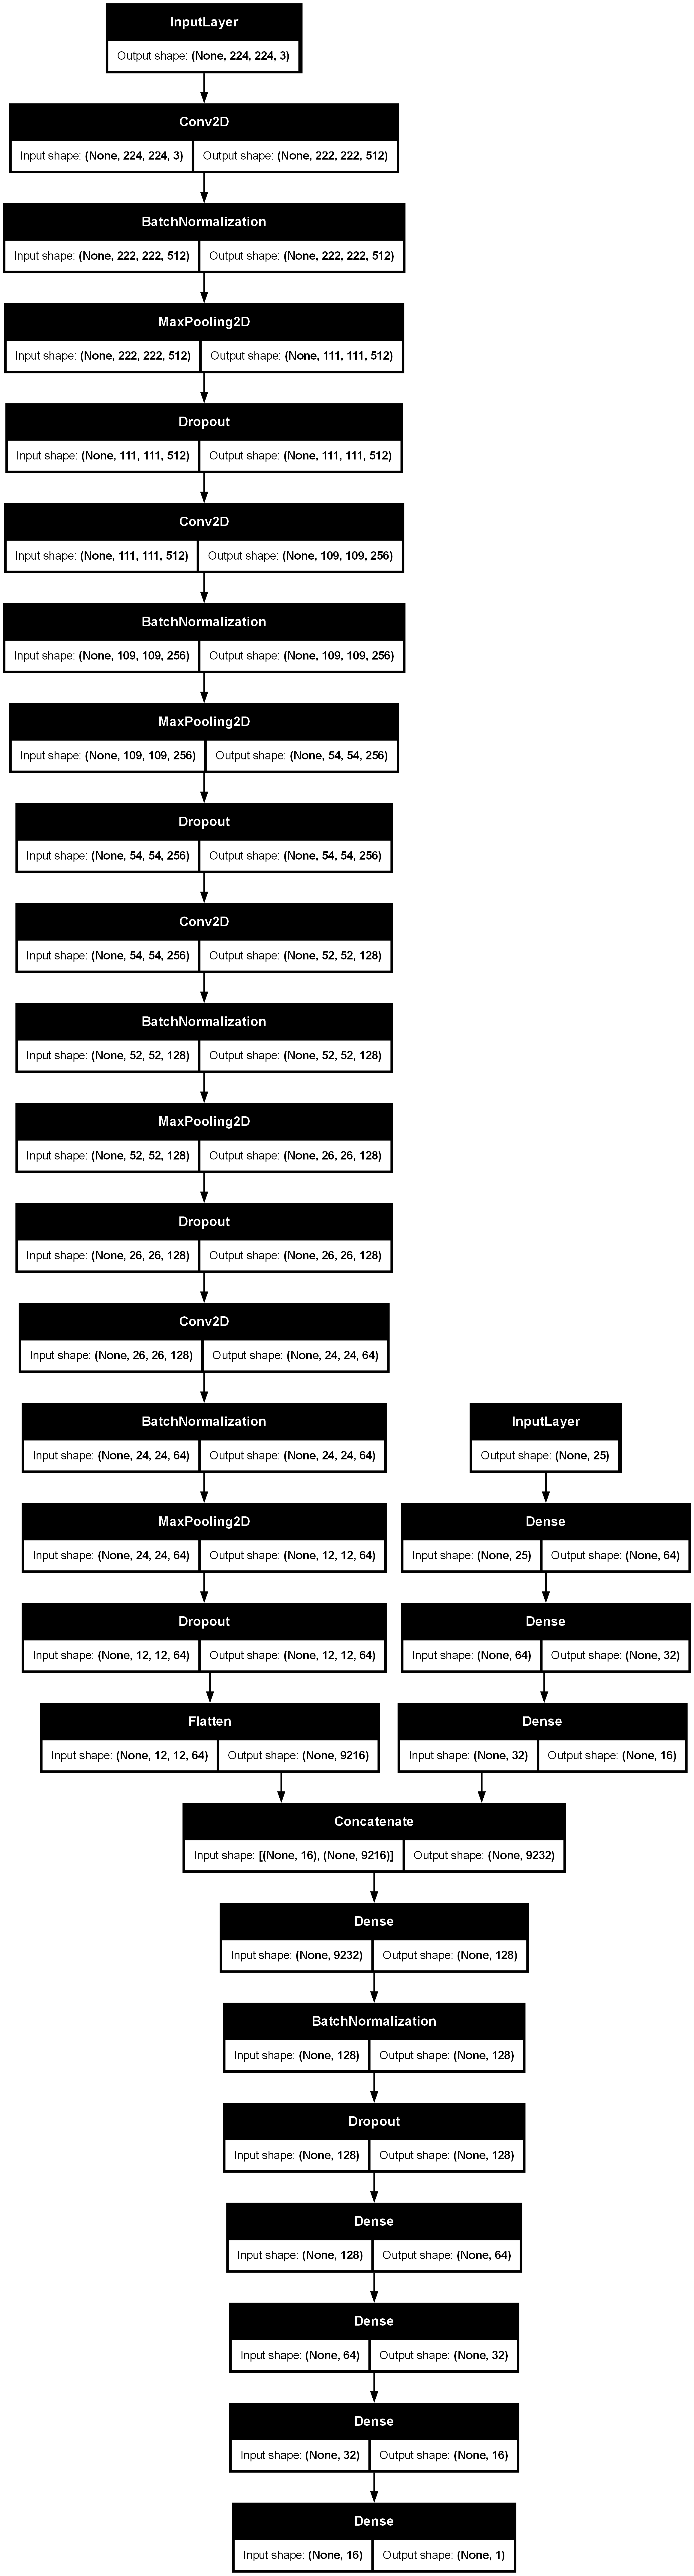

In [123]:
plot_model(model, to_file='glcm_cnn_model.png',  show_shapes=True)

In [124]:
callb = [
    ModelCheckpoint(
        'glcm_cnn_model_best.keras', 
        monitor='val_binary_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max'),

    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1),
        ]

In [125]:
data_inputs = tf.data.Dataset.from_tensor_slices((train_features, tf.expand_dims(train_images_norm, axis=-1)))
data_labels = tf.data.Dataset.from_tensor_slices(train_labels)

val_inputs = tf.data.Dataset.from_tensor_slices((val_features, tf.expand_dims(val_images_norm, axis=-1)))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

val_dataset = tf.data.Dataset.zip((val_inputs, val_labels)).batch(BATCH_SIZE).repeat()

dataset = tf.data.Dataset.zip((data_inputs, data_labels)).batch(BATCH_SIZE).repeat()



In [22]:
import keras_tuner as kt

# lets use keras tuner to find the best hyper parameters for our model architecture

def model_builder(hp):
    # we will build two models and concatenate them 

    # first model is the glcm model

    # glcm_model = keras.Sequential()
    glcm_model_input = keras.layers.Input(shape=(25,))
    # glcm_model.add(glcm_model_input)

    glcm_layer_1 = hp.Int('glcm_layer_1', min_value=64, max_value=256, step=64)
    glcm_layer_2 = hp.Int('glcm_layer_2', min_value=32, max_value=256, step=32)
    glcm_layer_3 = hp.Int('glcm_layer_3', min_value=16, max_value=256, step=16)

    glcm_model = keras.layers.Dense(glcm_layer_1, activation='relu')(glcm_model_input)
    glcm_model = keras.layers.Dense(glcm_layer_2, activation='relu')(glcm_model)
    glcm_model = keras.layers.Dense(glcm_layer_3, activation='relu')(glcm_model)

    # second model is the cnn model

    # cnn_model = keras.Sequential()
    cnn_model_input = keras.layers.Input(shape=(140,140,1))
    # cnn_model.add(cnn_model_input)

    hp_filters = hp.Int('filters', min_value=32, max_value=256, step=32)
    hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
    hp_kernel_regularizer = hp.Choice('kernel_regularizer', values=[0.001, 0.01, 0.1])
    hp_pool_size = hp.Int('pool_size', min_value=3, max_value=5, step=1)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

    cnn_dense_layer = hp.Int('cnn_dense_layer', min_value=32, max_value=512, step=32)

    cnn_model = keras.layers.Conv2D(filters=hp_filters, kernel_size=hp_kernel_size, strides=1, activation='relu', kernel_regularizer=l2(hp_kernel_regularizer))(cnn_model_input)
    cnn_model = keras.layers.BatchNormalization()(cnn_model)
    cnn_model = keras.layers.MaxPool2D(pool_size=(hp_pool_size,hp_pool_size))(cnn_model)
    cnn_model = keras.layers.Dropout(hp_dropout)(cnn_model)

    cnn_model = keras.layers.Conv2D(filters=hp_filters, kernel_size=hp_kernel_size, strides=1, activation='relu', kernel_regularizer=l2(hp_kernel_regularizer))(cnn_model)
    cnn_model = keras.layers.BatchNormalization()(cnn_model)
    cnn_model = keras.layers.MaxPool2D(pool_size=(hp_pool_size,hp_pool_size))(cnn_model)
    cnn_model = keras.layers.Dropout(hp_dropout)(cnn_model)

    cnn_model = keras.layers.Conv2D(filters=hp_filters, kernel_size=hp_kernel_size, strides=1, activation='relu', kernel_regularizer=l2(hp_kernel_regularizer))(cnn_model)
    cnn_model = keras.layers.BatchNormalization()(cnn_model)
    cnn_model = keras.layers.GlobalAveragePooling2D()(cnn_model)
    cnn_model = keras.layers.Dense(cnn_dense_layer, activation='relu')(cnn_model)
    cnn_model = keras.layers.Dropout(hp_dropout)(cnn_model)

    # concatenate the two models
    combined = keras.layers.Concatenate()([glcm_model, cnn_model])

    # combined_model = keras.Sequential()

    combined_layer_1 = hp.Int('combined_layer_1', min_value=32, max_value=256, step=32)
    combined_layer_2 = hp.Int('combined_layer_2', min_value=16, max_value=128, step=16)
    combined_layer_3 = hp.Int('combined_layer_3', min_value=8, max_value=64, step=8)
    combined_layer_4 = hp.Int('combined_layer_4', min_value=4, max_value=32, step=4)
    
    combined_model = keras.layers.Dense(combined_layer_1, activation='relu')(combined)
    combined_model = keras.layers.Dropout(hp_dropout)(combined_model)
    combined_model = keras.layers.Dense(combined_layer_2, activation='relu')(combined_model)
    combined_model = keras.layers.Dropout(hp_dropout)(combined_model)
    combined_model = keras.layers.Dense(combined_layer_3, activation='relu')(combined_model)
    combined_model = keras.layers.Dense(combined_layer_4, activation='relu')(combined_model)
    combined_model = keras.layers.Dense(1, activation='sigmoid')(combined_model)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 2e-4, 3e-4, 4e-4, 5e-4])

    aopt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model = keras.Model([glcm_model_input, cnn_model_input], combined_model)

    model.compile(optimizer=aopt, loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])

    return model 

    
    

In [23]:
import keras_tuner as kt

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner = kt.Hyperband(model_builder, objective='val_binary_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='enhanced_binary_classification')

tuner.search(dataset, epochs=EPOCH_NUM, validation_data=val_dataset, steps_per_epoch=STEP_SIZE, validation_steps=(len(val_features) // BATCH_SIZE), callbacks=[stop_early])





Trial 25 Complete [00h 01m 43s]
val_binary_accuracy: 0.7155172228813171

Best val_binary_accuracy So Far: 0.7306034564971924
Total elapsed time: 00h 56m 39s


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 140, 140,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 138, 138,  │      1,600 │ input_layer_5[0]… │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 138,  │        640 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 46, 46,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 46, 46,    │          0 │ max_pooling2d_4[… │
│ (Dropout)           │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 44, 44,    │    230,560 │ dropout_10[0][0]  │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        640 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 14, 14,    │          0 │ max_pooling2d_5[… │
│ (Dropout)           │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 12, 12,    │    230,560 │ dropout_11[0][0]  │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        640 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │      6,656 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 160)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     32,896 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 96)        │     15,456 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 16)        │      2,064 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 96)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 541,081 (2.06 MB)

 Trainable params: 540,121 (2.06 MB)

 Non-trainable params: 960 (3.75 KB)

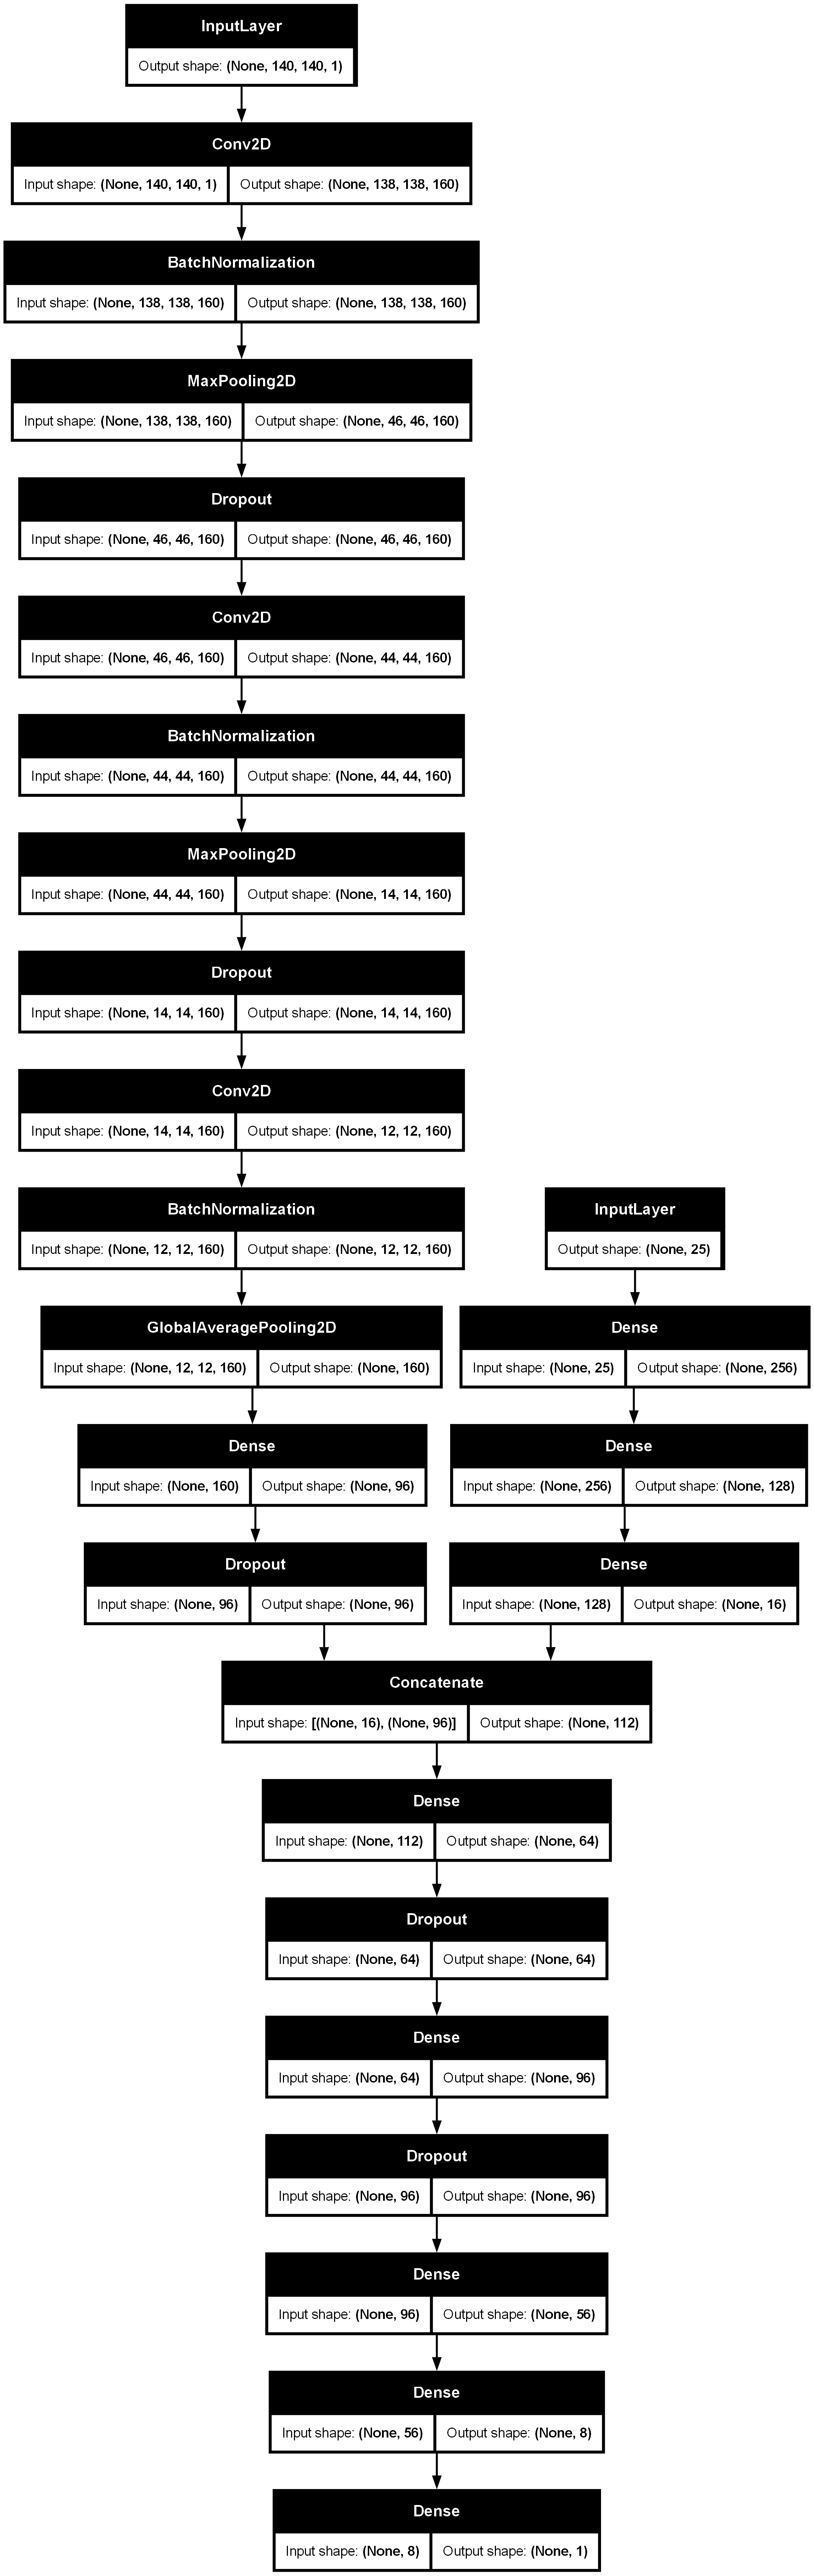

In [71]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

plot_model(model, to_file='glcm_cnn_model_kt.png',  show_shapes=True)


In [126]:
history_v1 = model.fit(dataset, validation_data=val_dataset, validation_steps=(len(val_features) // BATCH_SIZE) ,epochs=EPOCH_NUM, steps_per_epoch=STEP_SIZE, callbacks=callb)

Epoch 1/50


In [26]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

In [61]:
score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test binary accuracy: {score[1]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - auc_3: 0.4618 - binary_accuracy: 0.7845 - loss: 0.4325
Test loss: 0.5136092305183411 / Test binary accuracy: 0.7578125


In [62]:
history_v1.history.keys()

dict_keys(['auc_3', 'binary_accuracy', 'loss', 'val_auc_3', 'val_binary_accuracy', 'val_loss'])

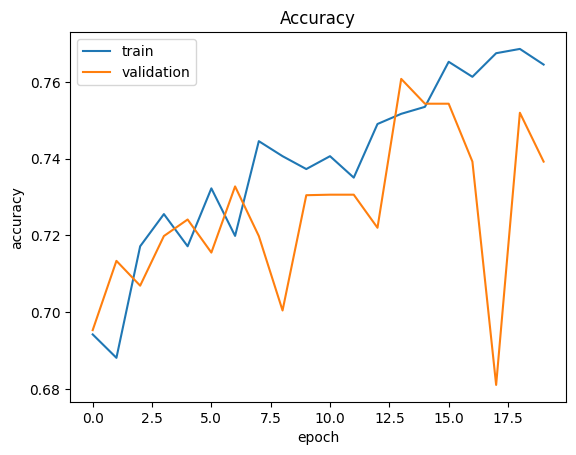

In [63]:
plt.plot(history_v1.history['binary_accuracy'])
plt.plot(history_v1.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

C:\Users\ot7sl\AppData\Local\Temp\ipykernel_27436\1255025542.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


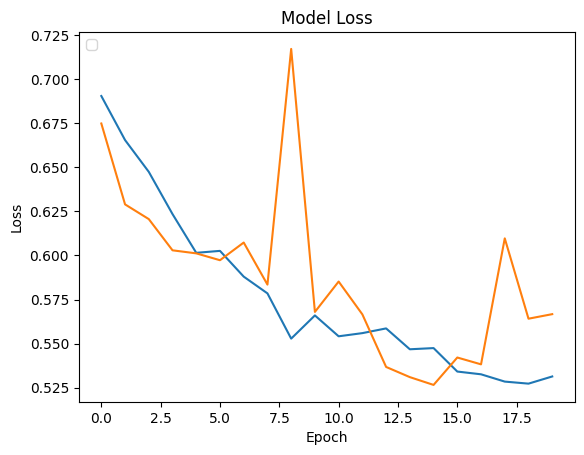

In [64]:
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

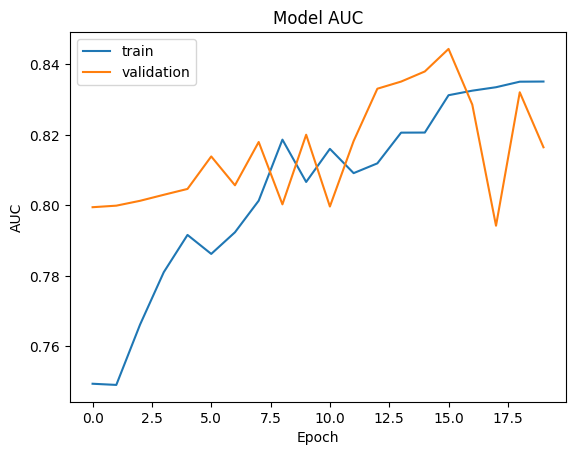

In [66]:
# plot the auc curve
plt.plot(history_v1.history['auc_3'])
plt.plot(history_v1.history['val_auc_3'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [67]:
# ROC / AUC

preds = model.predict(test_dataset, steps=STEP_SIZE_TEST, batch_size=BATCH_SIZE)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


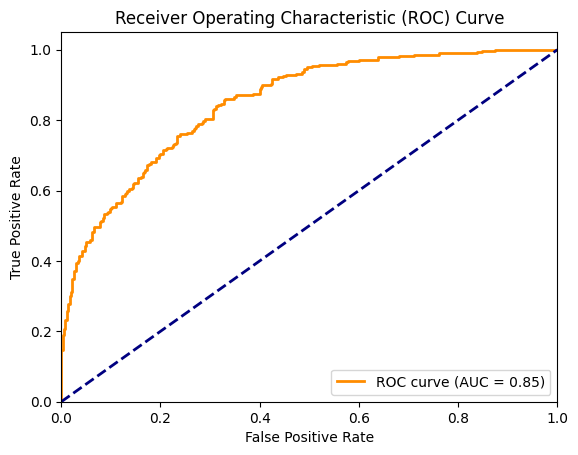

In [68]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels_test[:640], preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [69]:
rounded_array = np.where(preds >= 0.472, 1, 0)

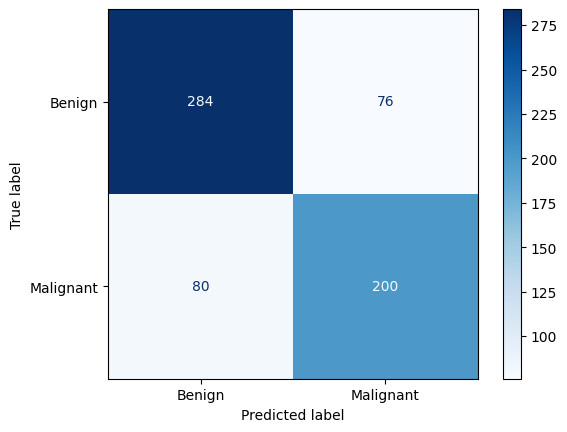

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_test[:640], rounded_array, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues, values_format='d')